In [44]:
import numpy as np
import wandb
from datetime import datetime
from pathlib import Path
from load_data import load_data, list_logs, load_labels
from preprocess_data import preprocess_logs, get_label_timeseries
from models.helpers import create_model_params
from models.buckling_model import BucklingModel
from models.double_slope_model import DoubleSlopeModel
import config as config
import argparse
from models.gru import GRUClassifier, train_gru_model, evaluate_gru_model
import torch

In [45]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]"]
heads_rename = ["timestamps", "force_sensor_v"]
f_s = 1000
fss = 568.5

log_names = list_logs(config.PAPER_EXPERIMENT_DATA_FOLDER)
log_names.drop([7, 158, 174], inplace=True, errors='ignore')
log_names.reset_index(drop=True, inplace=True)

In [49]:
first_backward = log_names[log_names['direction'] == 'Backward'].iloc[0]
print(f"First backward log at index: {first_backward}")
label = load_labels(first_backward.to_frame().T)
print(label)

First backward log at index: path             /home/boesch/TREX-Semester-Project/data/raw/Pa...
path_markers     /home/boesch/TREX-Semester-Project/data/raw/Pa...
datetime                                       2022-06-30 15:40:03
clot_index                                                       1
direction                                                 Backward
stiffness                                                      NaN
pressure                                                       NaN
clot_presence                                                 With
Name: 1, dtype: object
[   Start  End
1   26.6  9.3]


In [33]:
gru_model = GRUClassifier(input_size=1, hidden_size=16, num_layers=2, output_size=1)

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
idx = 0
first_curve_log = log_names.iloc[idx]
first_curve_data = load_data(first_curve_log.to_frame().T, heads_keep, heads_rename, fss)
plot = first_curve_data.copy()

preprocess_logs(first_curve_log.to_frame().T, first_curve_data, plot)
print(first_curve_data[0].head())
labels = load_labels(first_curve_log.to_frame().T)
label_timeseries = get_label_timeseries(labels, first_curve_data)[0]
print(label_timeseries.head())
x = first_curve_data[0][['force_sensor_mN']].values
x = (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)
y = label_timeseries['in_clot'].values
print(f"x shape: {x.shape}, y shape: {y.shape}")

1it [00:00, 196.74it/s]

Preprocessing time: 0.007 s
   timestamps  force_sensor_v  force_sensor_mN
0         5.0        0.855534         0.000000
1         5.2        0.853313         0.017155
2         5.4        0.855534        -0.032437
3         5.6        0.853313        -0.282703
4         5.8        0.857753        -0.011590
   timestamps  in_clot
0         5.0      0.0
1         5.2      0.0
2         5.4      0.0
3         5.6      0.0
4         5.8      0.0
x shape: (158, 1), y shape: (158,)


ValueError: x and y must have same first dimension, but have shapes (42689,) and (158, 1)

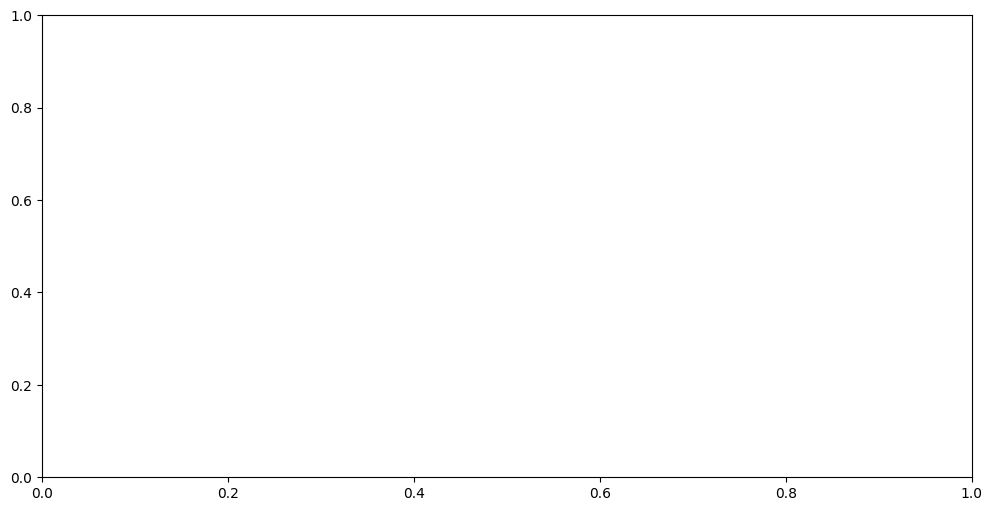

In [ ]:
# plot both x and y to verify
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(first_curve_data[0]['timestamps'], x, label='Normalized Force Sensor')
plt.plot(first_curve_data[0]['timestamps'], y, label='Clot Presence', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Value') 
plt.title('Force Sensor and Clot Presence Over Time')
plt.legend()
plt.show()

In [ ]:
# load model
model_path = "../models/gru_forward_model_2025-11-11_12-11-47.pt"
gru_model.load_state_dict(torch.load(model_path, map_location=device))
gru_model.to(device)
gru_model.eval()

GRUClassifier(
  (gru): GRU(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
# run first curve through the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
print(f"x_tensor shape: {x_tensor.shape}, y_tensor shape: {y_tensor.shape}")

x_tensor shape: torch.Size([1, 158, 1]), y_tensor shape: torch.Size([1, 158, 1])


In [ ]:
outputs = gru_model(x_tensor)
threshold = 0.5
preds = (outputs > threshold).float()
preds_sequence = preds.squeeze(0).cpu().numpy()  # shape: (seq_len, 1)
probs = outputs.squeeze(0).squeeze(-1).cpu().detach().numpy()  # shape: (seq_len,)
timestamps = first_curve_data[0]['timestamps']

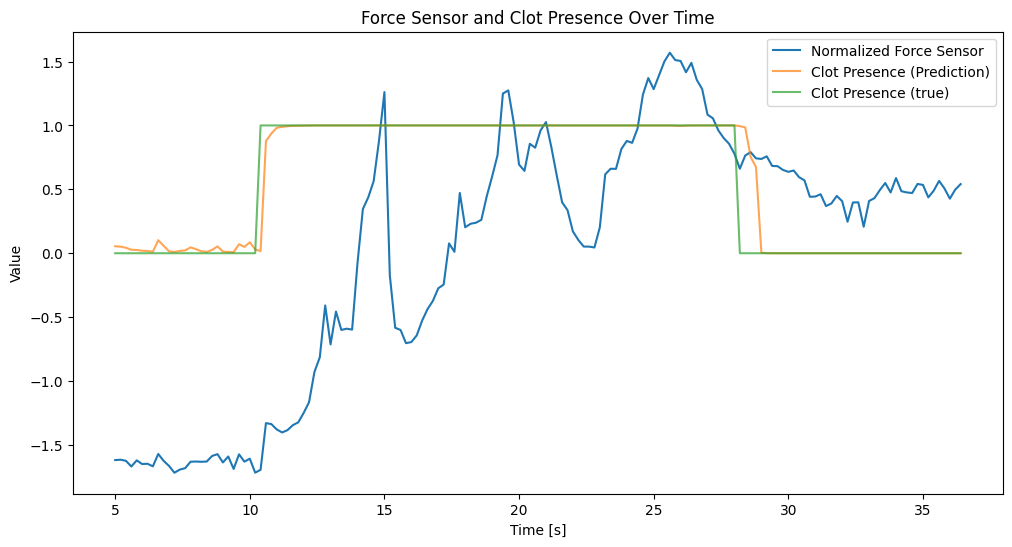

In [ ]:
# plot both x and y to verify
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(first_curve_data[0]['timestamps'], x, label='Normalized Force Sensor')
plt.plot(first_curve_data[0]['timestamps'], probs, label='Clot Presence (Prediction)', alpha=0.7)
plt.plot(first_curve_data[0]['timestamps'], y, label='Clot Presence (true)', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Value') 
plt.title('Force Sensor and Clot Presence Over Time')
plt.legend()
plt.show()